### Spark Exploration Exercises

In [3]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
import pyspark.sql.functions as f

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import when
from pyspark.sql.functions import lit
from pydataset import data
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.getOrCreate()
source_df = spark.read.csv("source.csv", sep=",", header=True, inferSchema=True)
case_df = spark.read.csv("case.csv", sep=",", header=True, inferSchema=True)
dept_df = spark.read.csv("dept.csv", sep=",", header=True, inferSchema=True)
source_df.show(5)
case_df.show(5)
dept_df.show(5)

+---------+----------------+
|source_id| source_username|
+---------+----------------+
|   100137|Merlene Blodgett|
|   103582|     Carmen Cura|
|   106463| Richard Sanchez|
|   119403|  Betty De Hoyos|
|   119555|  Socorro Quiara|
+---------+----------------+
only showing top 5 rows

+----------+----------------+----------------+------------+---------+-------------------+-----------+----------------+--------------------+-----------+-----------+---------+--------------------+----------------+
|   case_id|case_opened_date|case_closed_date|SLA_due_date|case_late|      num_days_late|case_closed|   dept_division|service_request_type|   SLA_days|case_status|source_id|     request_address|council_district|
+----------+----------------+----------------+------------+---------+-------------------+-----------+----------------+--------------------+-----------+-----------+---------+--------------------+----------------+
|1014127332|     1/1/18 0:42|    1/1/18 12:29|9/26/20 0:42|       NO| -998.508

In [7]:
case_df = case_df.withColumnRenamed("SLA_due_date", "case_due_date")
case_df = case_df.withColumn("case_closed", f.expr('case_closed == "YES"')).withColumn("case_late", f.expr('case_late == "YES"'))
case_df = case_df.withColumn("council_district", f.col("council_district").cast("string"))

fmt = "M/d/yy H:mm"
case_df = (
    case_df.withColumn("case_opened_date", f.to_timestamp("case_opened_date", fmt))
     .withColumn("case_closed_date", f.to_timestamp("case_closed_date", fmt))
    .withColumn("case_due_date", f.to_timestamp("case_due_date", fmt))
)

In [8]:
join_df = (   
    case_df.join(dept_df, "dept_division", "left")
    .drop(dept_df.dept_division)
    .drop(dept_df.dept_name)
    .drop(case_df.dept_division)
    .withColumnRenamed("standardized_dept_name", "department")
    .withColumn("dept_subject_to_SLA", f.col("dept_subject_to_SLA") == "YES")
    .join(source_df, "source_id", "left")
    .drop(source_df.source_id)
)

In [9]:
join_df.show(1, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------
 source_id            | svcCRMLS                             
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 5                                    
 department           | Animal Care Services                 
 dept_subject_to_SLA  | true                                 
 source_

---

### 1.

In [11]:
join_df.groupby('department').count().show(20, truncate=False)

+------------------------+------+
|department              |count |
+------------------------+------+
|Solid Waste             |286287|
|Animal Care Services    |119362|
|Trans & Cap Improvements|97841 |
|Parks & Recreation      |19964 |
|Customer Service        |2889  |
|Metro Health            |5313  |
|City Council            |34    |
|DSD/Code Enforcement    |323579|
+------------------------+------+



<AxesSubplot:ylabel='department'>

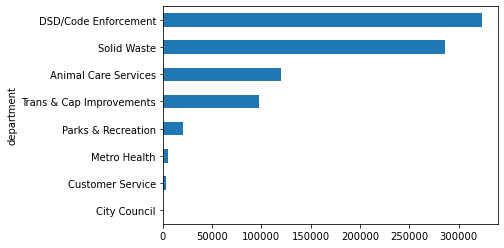

In [20]:
(
    join_df.groupby('department')
    .count()
    .toPandas()
    .set_index("department")["count"]
    .sort_values()
    .plot.barh()
)

---

### 2.

In [ ]:
(
    join_df.filter(join_df.case_late == True)
    .groupby('department')
    .count()
    .show()
)

In [34]:
df1 = join_df.groupby('department').count().toPandas()
df2 = (
    join_df.filter(join_df.case_late == True)
    .groupby('department')
    .count()
    .toPandas()
)

In [35]:
df1

,department,count
0,Solid Waste,286287
1,Animal Care Services,119362
2,Trans & Cap Improvements,97841
3,Parks & Recreation,19964
4,Customer Service,2889
5,Metro Health,5313
6,City Council,34
7,DSD/Code Enforcement,323579


In [36]:
df2

,department,count
0,Solid Waste,33729
1,Animal Care Services,23751
2,Trans & Cap Improvements,5529
3,Parks & Recreation,3810
4,Customer Service,2035
5,Metro Health,854
6,DSD/Code Enforcement,26439


In [41]:
df1 = df1.rename(columns={'count':'total'})
df1 = df1.set_index('department')
df2 = df2.rename(columns={'count':'late'})
df2 = df2.set_index('department')
df3 = pd.concat([df1, df2], axis=1)

In [42]:
df3

,total,late
department,,
Solid Waste,286287,33729.0
Animal Care Services,119362,23751.0
Trans & Cap Improvements,97841,5529.0
Parks & Recreation,19964,3810.0
Customer Service,2889,2035.0
Metro Health,5313,854.0
City Council,34,NaN
DSD/Code Enforcement,323579,26439.0


In [43]:
df3['percentage_late'] = df3.late / df3.total
df3

,total,late,percentage_late
department,,,
Solid Waste,286287,33729.0,0.117815
Animal Care Services,119362,23751.0,0.198983
Trans & Cap Improvements,97841,5529.0,0.056510
Parks & Recreation,19964,3810.0,0.190844
Customer Service,2889,2035.0,0.704396
Metro Health,5313,854.0,0.160738
City Council,34,NaN,NaN
DSD/Code Enforcement,323579,26439.0,0.081708


In [45]:
df3 = df3.fillna(0)

In [46]:
df3

,total,late,percentage_late
department,,,
Solid Waste,286287,33729.0,0.117815
Animal Care Services,119362,23751.0,0.198983
Trans & Cap Improvements,97841,5529.0,0.056510
Parks & Recreation,19964,3810.0,0.190844
Customer Service,2889,2035.0,0.704396
Metro Health,5313,854.0,0.160738
City Council,34,0.0,0.000000
DSD/Code Enforcement,323579,26439.0,0.081708


<AxesSubplot:ylabel='department'>

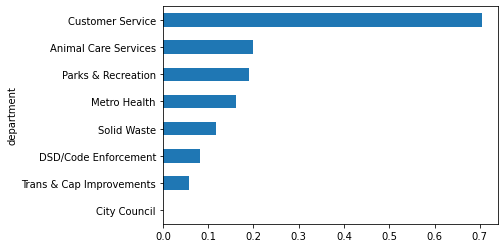

In [49]:
df3.percentage_late.sort_values().plot.barh()

---

### 3.

In [52]:
join_df.select('department', 'num_days_late').groupby('department').agg(f.avg('num_days_late')).show()

+--------------------+-------------------+
|          department| avg(num_days_late)|
+--------------------+-------------------+
|         Solid Waste| -2.200057513672161|
|Animal Care Services|-226.51783940550325|
|Trans & Cap Impro...| -20.61283735405272|
|  Parks & Recreation| -5.251521960055153|
|    Customer Service| 59.737091496300785|
|        Metro Health| -4.911766979607001|
|        City Council|               null|
|DSD/Code Enforcement| -38.36938892614484|
+--------------------+-------------------+



In [74]:
#change negative values for days late to '0'
join_df= (
    join_df.withColumn('num_days_late', when(f.col('num_days_late') < 0, 0).otherwise(f.col('num_days_late')))
    #.show(3, vertical=True, truncate=False)
)


In [75]:
join_df.show(1, vertical=True)

-RECORD 0------------------------------------
 source_id            | svcCRMLS             
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | 0.0                  
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 request_address      | 2315  EL PASO ST,... 
 council_district     | 5                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 source_username      | svcCRMLS             
only showing top 1 row



In [77]:
#group by department and average days late
(
    join_df.select('department', 'num_days_late')
    .groupby('department')
    .agg(f.avg('num_days_late'))
    .show()
)

+--------------------+------------------+
|          department|avg(num_days_late)|
+--------------------+------------------+
|         Solid Waste|0.8420465861844303|
|Animal Care Services| 4.665498865255836|
|Trans & Cap Impro...|0.6025638849370918|
|  Parks & Recreation| 4.280201633153626|
|    Customer Service| 62.11538612520006|
|        Metro Health|1.0439438096772067|
|        City Council|              null|
|DSD/Code Enforcement|  4.04506510898149|
+--------------------+------------------+



<AxesSubplot:ylabel='department'>

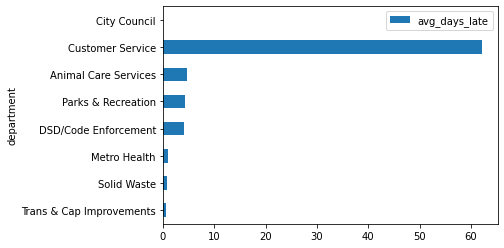

In [83]:
#plot the above table
(
    join_df.select('department', 'num_days_late')
    .groupby('department')
    .agg(f.avg('num_days_late').alias('avg_days_late'))
    .toPandas()
    .set_index('department')
    .sort_values(by='avg_days_late')
    .plot.barh()
)

---

### 4.

In [85]:
join_df.groupby('service_request_type').agg(f.max('num_days_late')).show()

+--------------------+------------------+
|service_request_type|max(num_days_late)|
+--------------------+------------------+
|Minimum Housing-O...|305.94459489999997|
|        Tree Removal|       320.9957986|
| Service Information|       237.0015741|
|    Sign Maintenance|168.99849540000002|
|Park Building Mai...|325.76707180000005|
|Brush Property Da...|       8.944780093|
|Graffiti: Private...|       175.0887731|
|Traffic Sign Graf...|167.64583330000002|
|License Renewal I...|       101.8816667|
|   Sewer Line Broken|180.19297450000002|
|Zoning: Multi-Fam...|        297.128125|
|Engineering Inves...|       6.713449074|
|    Zoning: Setbacks|       377.8053125|
|  Traffic Sign Faded|       21.17309028|
|     Permits, Fences|       305.9244792|
|Certificates of O...|       378.3227083|
|  Dead Animal - Misc| 8.127928241000001|
|Garage Sales No P...|       78.67309028|
|   Water No Services|       161.9871759|
|Major Park Improv...|       214.0287037|
+--------------------+------------

In [94]:
(
    join_df.groupby('service_request_type')
    .agg(f.max('num_days_late').alias('max_days_late'))
    .sort('max_days_late', ascending=False).show(5)
)

+--------------------+------------------+
|service_request_type|     max_days_late|
+--------------------+------------------+
|        Bandit Signs|       519.6980787|
|   No Address Posted|       514.9381944|
|    Permits Building|       506.1483218|
|  Zoning: Junk Yards|        494.949838|
|Zoning: Recycle Yard|494.94844910000006|
+--------------------+------------------+
only showing top 5 rows



---

### 5.

In [98]:
(
    join_df.filter(join_df.department == 'DSD/Code Enforcement')
    .groupby('service_request_type')
    .count().sort('count', ascending=False)
    .show(truncate=False)
)

+--------------------------------------+-----+
|service_request_type                  |count|
+--------------------------------------+-----+
|Overgrown Yard/Trash                  |66403|
|Bandit Signs                          |32968|
|Front Or Side Yard Parking            |28920|
|Junk Vehicle On Private Property      |21649|
|Alley-Way Maintenance                 |20293|
|Right Of Way/Sidewalk Obstruction     |17836|
|Vacant Lot/Overgrown/Trash            |9497 |
|Minimum Housing-Owner Occupied        |8617 |
|Graffiti: Private Property (Corridors)|8525 |
|Minimum Housing-Tenant Occupied       |8104 |
|Dang. Premises/CL/SEC                 |8004 |
|"Vacant Lot-Private (12"")"           |7875 |
|Brush Violations                      |7530 |
|Permits Building                      |6950 |
|Vacant House Overgrown Yard           |6278 |
|Graffiti: Building                    |4572 |
|Low Hanging Limbs on Streets/Sidewalk |4107 |
|Graffiti Public Property              |4104 |
|CPS Energy W

---

### 6. 